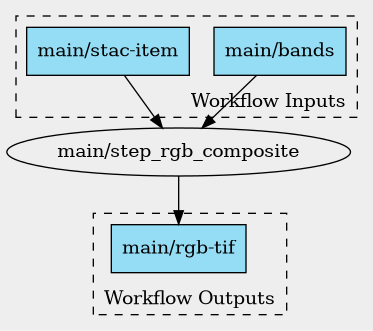

In [2]:
cwltool --print-dot ../cwl/06-nested-workflows/nested-workflow.cwl 2> /dev/null | dot -Tpng | display

In [1]:
cwltool ../cwl/06-nested-workflows/nested-workflow.cwl --stac-item https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2B_53HPA_20210723_0_L2A 

INFO /home/fbrito/.local/bin/cwltool 3.1.20240508115724
INFO Resolved '../cwl/06-nested-workflows/nested-workflow.cwl' to 'file:///data/work/github/eoepca-plus/how-to/cwl/06-nested-workflows/nested-workflow.cwl'
INFO [workflow ] start
INFO [workflow ] starting step step_rgb_composite
INFO [step step_rgb_composite] start
INFO [workflow step_rgb_composite] start
INFO [workflow step_rgb_composite] starting step step_curl
INFO [step step_curl] start
INFO [job step_curl] /tmp/bn8vsoj9$ docker \
    run \
    -i \
    --mount=type=bind,source=/tmp/bn8vsoj9,target=/igkYGp \
    --mount=type=bind,source=/tmp/u6ii4yxx,target=/tmp \
    --workdir=/igkYGp \
    --read-only=true \
    --log-driver=none \
    --user=1000:1000 \
    --rm \
    --cidfile=/tmp/ucslbg9q/20241210174617-268351.cid \
    --env=TMPDIR=/tmp \
    --env=HOME=/igkYGp \
    docker.io/curlimages/curl:latest \
    curl \
    https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2B_53HPA_20210723_0_L2A